<a href="https://colab.research.google.com/github/cfuther/Capstone_2_Forecast_webpage_visits/blob/master/web_traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This project is to forecast future web traffic for approximately 145,000 Wikipedia articles. Originally a kaggle competition at https://www.kaggle.com/c/web-traffic-time-series-forecasting   
Main goals of this project include:   
1) explore the time series data and analyze trend, seasonality
2) get familiar with state-of-the-art time series forecast methods including Prophet and RNN

# Data Exploration


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/web_traffic_forecast')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /web_traffic_forecast


In [4]:
!ls '/web_traffic_forecast/My Drive/web_traffic_forecast'

features.py  __pycache__	      train_2.csv
key_2.csv    sample_submission_2.csv  web_traffic_prediction.ipynb


In [5]:
train2 = pd.read_csv('/web_traffic_forecast/My Drive/web_traffic_forecast/train_2.csv')
train2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [6]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [7]:
train2.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
2015-07-05    20659
2015-07-06    20483
2015-07-07    20664
2015-07-08    20294
2015-07-09    20244
2015-07-10    20342
2015-07-11    20525
2015-07-12    20485
2015-07-13    20399
2015-07-14    20140
2015-07-15    20106
2015-07-16    19987
2015-07-17    20048
2015-07-18    20295
2015-07-19    20142
2015-07-20    19979
2015-07-21    19688
2015-07-22    19573
2015-07-23    19581
2015-07-24    19593
2015-07-25    19589
2015-07-26    19865
2015-07-27    19759
2015-07-28    19553
2015-07-29    19347
              ...  
2017-08-12     3595
2017-08-13     3679
2017-08-14     3724
2017-08-15     3596
2017-08-16     3734
2017-08-17     3945
2017-08-18     3817
2017-08-19     3973
2017-08-20     4170
2017-08-21     3934
2017-08-22     3794
2017-08-23     1059
2017-08-24     1092
2017-08-25     1063
2017-08-26     3471
2017-08-27     1069
2017-08-28     1955
2017-08-29     1304
2017-08-30     2724


Since the dataset does not distinguish between traffic values of zero and missing values, fill na with 0

In [0]:
train2.fillna(0,inplace=True)

In [0]:
# convert float value to integer to save memory
train2 = train2.astype(int,errors='ignore')

In [10]:
train2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: int64(803), object(1)
memory usage: 908.0 MB


In [11]:
key2 = pd.read_csv('/web_traffic_forecast/My Drive/web_traffic_forecast/key_2.csv')
key2.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


In [12]:
key2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 2 columns):
Page    object
Id      object
dtypes: object(2)
memory usage: 137.2+ MB


In [13]:
sample2 = pd.read_csv('/web_traffic_forecast/My Drive/web_traffic_forecast/sample_submission_2.csv')
sample2.head()

,Id,Visits
0,0b293039387a,0
1,7114389dd824,0
2,057b02ff1f09,0
3,bd2aca21caa3,0
4,c0effb42cdd5,0


In [14]:
sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 2 columns):
Id        object
Visits    int64
dtypes: int64(1), object(1)
memory usage: 137.2+ MB


# Are visits related to language?

In [15]:
import re
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train2['lang'] = train2.Page.map(get_language)

from collections import Counter

print(Counter(train2.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish. Need to check if there is significant difference between patterns of various languages. If yes, need to build seperate models. 

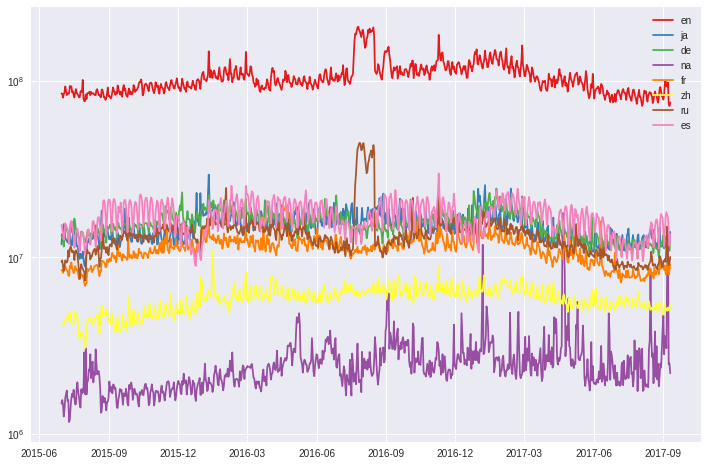

In [16]:
# plot the time series of the total visits per language
language = ['en','ja','de','na','fr','zh','ru','es']
palette = plt.get_cmap('Set1')

time = pd.to_datetime(train2.columns[1:804])
fig = plt.figure(figsize=(12,8))
for i in range(8):
  plt.plot(time,train2[train2.lang == language[i]].sum(axis=0)[1:804],label=language[i],color=palette(i))
plt.yscale('log')
plt.legend()
plt.show()

There are a few interesting patterns based on languages:  
1) English articles in general has more visits than other languages as expected because English is the most widely used language in regions having access to Wikipedia   
2) media pages have greater variations compared to other articles  
3) English and Russian articles experienced spike in visits during 2016-7 ~ 2016-8 probably due to US election and Olympics   
4) Spanish articles had dip around January of each year probably due to celebration of Día de los Reyes Magos.


# Check Trend

In [0]:
# get index of most visited article per language
language = ['en','ja','de','na','fr','zh','ru','es']
max_visit_index = []

for lang in language: 
  max_visit_index.append(train2[train2.lang==lang].sum(axis=1).nlargest(1).index[0])

In [18]:
max_visit_index

[38573, 120336, 139119, 45056, 27330, 28727, 99322, 92205]

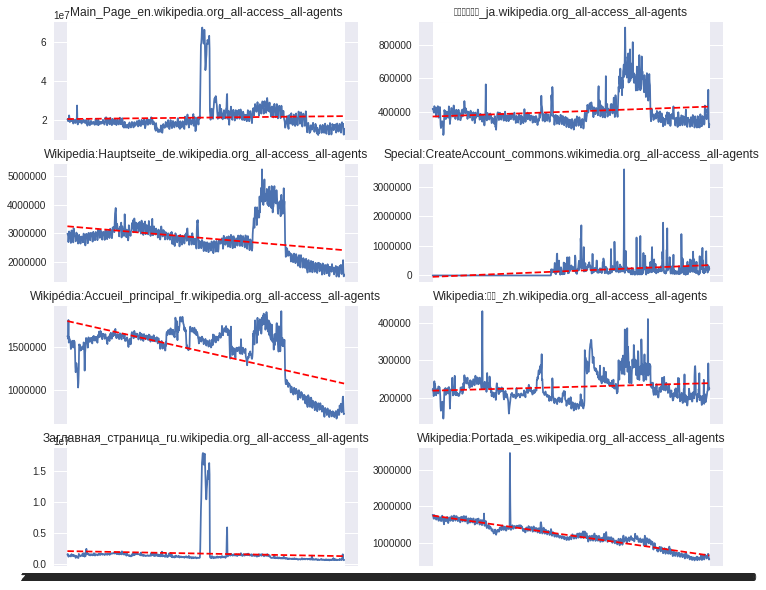

In [19]:
# plot the most visited articles
x = [i for i in range(len(time))]
timelabel = [str(i) for i in time]
fig = plt.figure(figsize=(12,10))
for i in range(len(max_visit_index)):
  ax = fig.add_subplot(4,2,i+1)
  plt.plot(train2.iloc[max_visit_index[i],1:804])
  z = np.polyfit(x,train2.iloc[max_visit_index[i],1:804], 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r--")
  plt.title(train2.iloc[max_visit_index[i],0])
  ax.set_xticklabels(timelabel)
  if i < 6:
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.show()

The mosted visited German, French and Spanish page show a clear decreasing trend, while other pages do not demonstrate a significant trend. 

# Check Seasonality

In [0]:
# keep only visit 
data = train2.iloc[:,1:804]

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


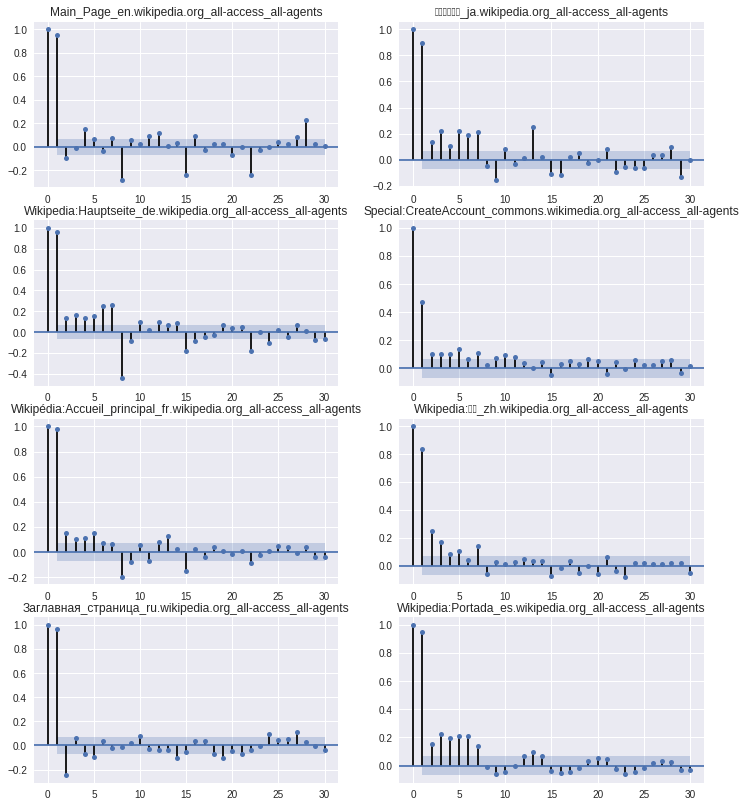

In [21]:
# check autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(12, 14))
for i in range(len(max_visit_index)):
  ax = fig.add_subplot(4,2,i+1)
  plot_pacf(data.iloc[max_visit_index[i],:],ax=ax,lags=30)
  plt.title(train2.iloc[max_visit_index[i],0])
plt.show()

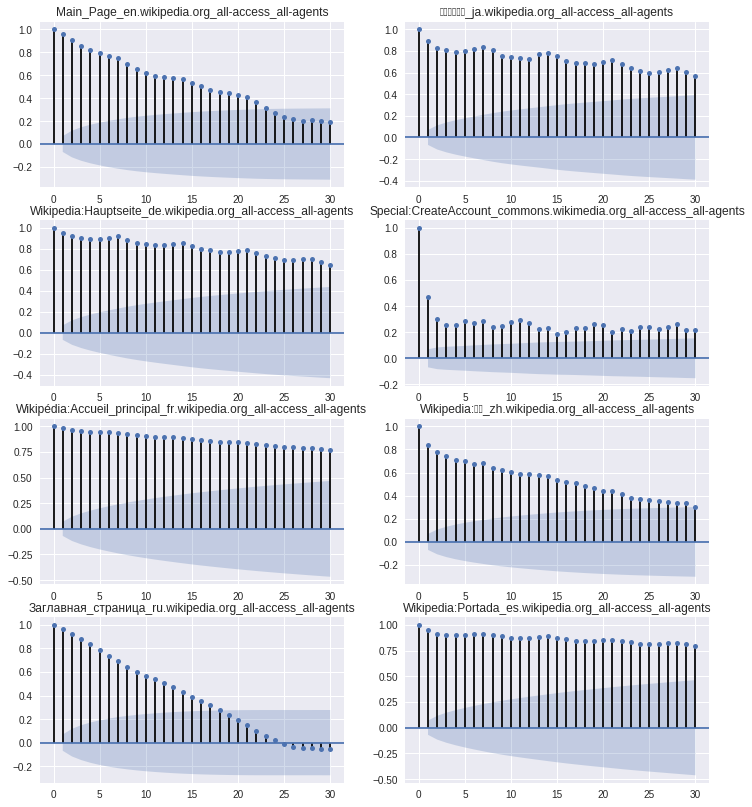

In [22]:
fig = plt.figure(figsize=(12, 14))
for i in range(len(max_visit_index)):
  ax = fig.add_subplot(4,2,i+1)
  plot_acf(data.iloc[max_visit_index[i],:],ax=ax,lags=30)
  plt.title(train2.iloc[max_visit_index[i],0])
plt.show()

Here I used the most visited page per language as an example to explore seasonality. PACF (partial autocorrelation function) and ACF (autocorrelation function) were applied but PACF gave a clearer pattern than ACF because it removes the intermediate correlation. Based on PACF, English based page has a clear weekly seasonality, German and French pages show similar patterns. Visits of most pages are correlated to the visits of the prior day, while Japanese, Spanish and Chinese pages are corralted to the visits of the past week.


# Check Stationarity
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.  
Some models like ARIMA require stationarity to forecast. To detect stationarity, **Augmented Dickey-Fuller test** can be used. The null hypothesis of the test is that the time series is not stationary. If failed to be rejected (p-value > a threshold, say 0.05), it suggests the time series is non-stationary. If rejected when p-value < 0.05, the null hypothesis is rejected and it means the time series is stationary.   
Detrending and seasonality removal may be needed to transform the data to stationary. Common approaches include *transformation* (Log, square root, etc), *smooting* (rolling average, monthly average etc), *differencing* (first order difference, difference with average). 

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(ds,ax):
  # pass the series of data to calculate and plot rolling mean and standard deviation
  rollingmean = ds.rolling(7).mean()
  rollingstd = ds.rolling(7).std()
  
  ax.plot(ds,label='original_data')
  ax.plot(rollingmean,label='rolling_mean')
  ax.plot(rollingstd,label='rolling_std')
  ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
  ax.legend()
  
  # Perform Dickey-Fuller test:
  result = adfuller(ds)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

ADF Statistic: -4.493674
p-value: 0.000202
ADF Statistic: -2.014396
p-value: 0.280297
ADF Statistic: -1.615495
p-value: 0.475092
ADF Statistic: -4.080086
p-value: 0.001045
ADF Statistic: -0.413123
p-value: 0.907885
ADF Statistic: -3.534758
p-value: 0.007138
ADF Statistic: -5.600987
p-value: 0.000001
ADF Statistic: -0.446802
p-value: 0.901986


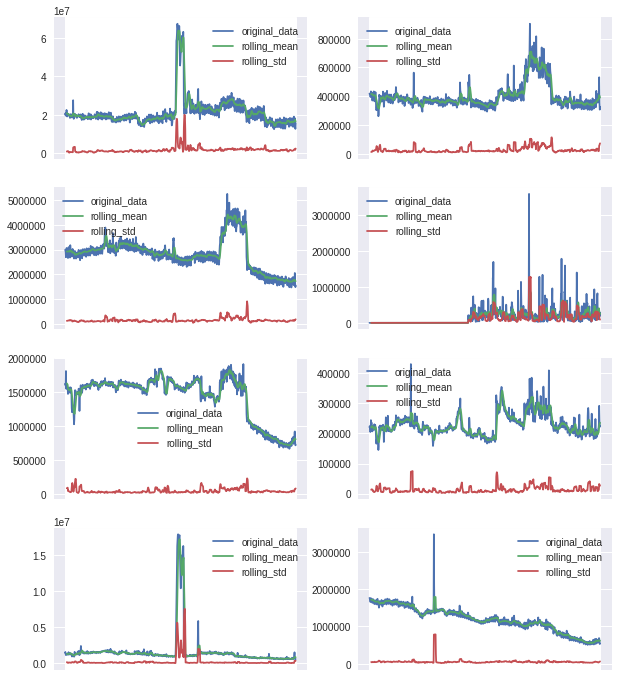

In [24]:
fig = plt.figure(figsize=(10, 12))
for i in range(len(max_visit_index)):
  ax = fig.add_subplot(4,2,i+1)
  test_stationary(data.iloc[max_visit_index[i],:],ax)
plt.show()

Based on the p-value of the adf test, the 1st, 4th, 6th and 7th web article are stationary (p-value < 0.05), while the rest are non-stationary

ADF Statistic: -6.261854
p-value: 0.000000
ADF Statistic: -5.545294
p-value: 0.000002
ADF Statistic: -7.664871
p-value: 0.000000
ADF Statistic: -13.298160
p-value: 0.000000


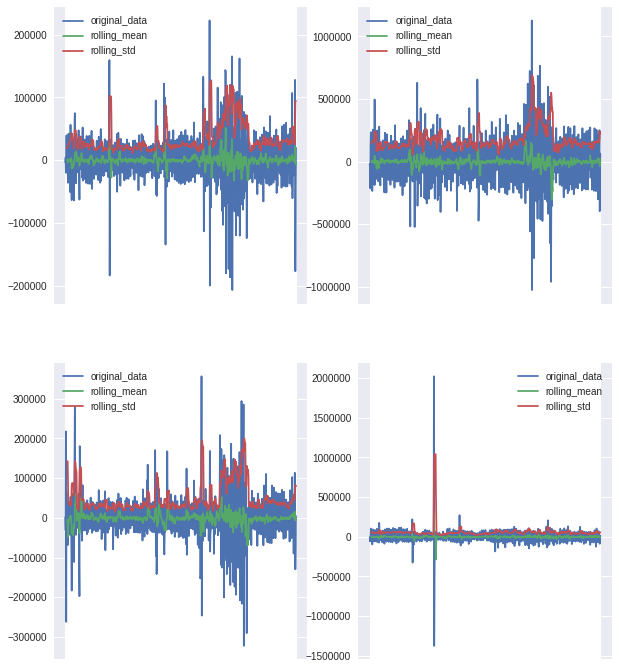

In [25]:
# convert non-stationary data to stationary
idx = [2,3,5,8]
non_sta_ind = [max_visit_index[i-1] for i in idx]

fig = plt.figure(figsize=(10,12))
# first order differencing
for i in range(len(non_sta_ind)):
  ds_diff = data.iloc[non_sta_ind[i],:].diff()
  ds_diff.dropna(inplace=True)
  ax = fig.add_subplot(2,2,i+1)
  test_stationary(ds_diff,ax)
plt.show()

After differening, all the four non-stationary time series become stationary with *p-value* < 0.05.

# Define Metrics: SMAPE
SMAPE (Symmetric mean absolute percentage error) is used as metric to evalute forecast model performance. It is absolute difference between actual value and forecast value is divided by half the sum of absolute values of the actual value and the forecast value. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n.

In [0]:
def SMAPE(y_actual,y_forecast):
  
  hal_sum = (np.abs(y_actual)+np.abs(y_forecast))/2
  
  dif = np.abs(y_actual-y_forecast)/hal_sum
  dif[hal_sum == 0] = 0
  
  return 100*np.nanmean(dif)

# Forecast

The next session is to forecast page visits. The most visited page of each language will be used as an example. 3 types of models are examined: ARIMA, Prophet, and RNN

# ARIMA
ARIMA = Auto-Regressive Integrated Moving Average.
Assumptions. The time-series is stationary.
Depends on:
1. Number of AR (Auto-Regressive) terms (p).
2. Number of I (Integrated or Difference) terms (d).
3. Number of MA (Moving Average) terms (q).

p and q can be determined using ACF and PACF plots:  
p – Lag value where the PACF chart crosses the upper confidence interval for the first time.  
q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

In [27]:
# train-test split
from datetime import date
from datetime import timedelta

train_start = date(2015,7,1)
train_end = date(2017,5,31)
test_start = date(2017,6,1)
test_end = date(2017,9,10)
len_train = (train_end - train_start + timedelta(days=1)).days
len_test = (test_end - test_start + timedelta(days=1)).days
print(len_train)
print(len_test)
train_dates = [train_start + timedelta(days=i) for i in range(len_train)]
test_dates = [test_start + timedelta(days=i) for i in range(len_test)]



701
102


701
102


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


700
102
700
102
701
102
700
102
701
102
701
102
700
102


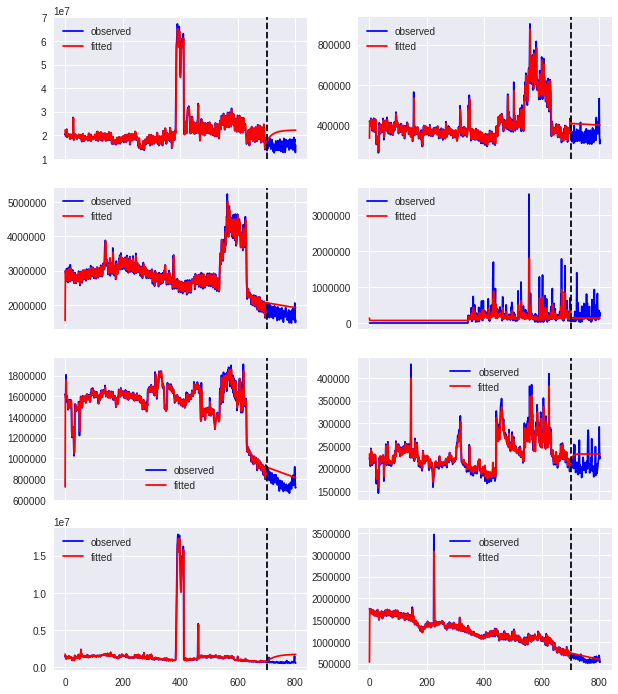

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
# parameter obtained from ACF and PACF plots
para_arima = [[1,0,0],[1,1,0],[1,1,0],[1,0,0],[1,1,0],[1,0,0],[1,0,0],[1,1,0]]
smape_arima = []

# fit model and plot
fig = plt.figure(figsize=(10,12))
for i in range(8):
  p,d,q = para_arima[i]
  
  # train-test split
  X = data.iloc[max_visit_index[i],:].values
  X = X.astype('float64')
  X_train = X[0:len_train]
  X_test = X[len_train:len_train+len_test]
  
  X_fitted = np.zeros(len_train+len_test)
    
  # model and predict
  model = ARIMA(X_train,order=(p,d,q))
  model_fit = model.fit(disp=-1)  
  print(len(model_fit.fittedvalues))
  
  future_fit = model_fit.predict(start=702,end=802)
  print(len(future_fit))
  
  # invert if differenced
  if d == 1:
    X_fitted[0] = X[0]
    for j in range(0,len_train):
      X_fitted[j] = X[j-1] + model_fit.fittedvalues[j-1] 
    for j in range(len_train,len_train+len_test):
      X_fitted[j] = X_fitted[j-1] + future_fit[j-len_train]
  else:
    for j in range(0,len_train):
      X_fitted[j] = model_fit.fittedvalues[j] 
    for j in range(len_train,len_train+len_test):
      X_fitted[j] = future_fit[j-len_train]
      
  #calculate sampe of tested period
  smape_arima.append(SMAPE(X_test,X_fitted[len_train:len_train+len_test]))
  
  # plot fit
  ax = fig.add_subplot(4,2,i+1)
  ax.plot(X,color='blue',label='observed')
  ax.plot(X_fitted, color = 'red',label='fitted')
  #ax.plot(range(len_train,len_train+len_test),forecast,color='red')
  ax.axvline(x=len_train,color='k', linestyle='--')
  ax.legend()
  if i < 6:
    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

plt.show()

In [29]:
print(smape_arima)
print(np.mean(smape_arima))

[27.950781349132065, 14.279582274458274, 11.497063178296742, 71.05801552398965, 11.365073005046336, 12.437258165917967, 73.72384320647778, 9.87882542694595]
29.023805266283098


ARIMA model was applied to the most visited pages per language. Use 702 days of data to train and 101 days to test. Order of differencing in ARIMA model was set to 1 for the four non-stationary time series, which is equivalent to first-order differencing which convert them stationary.  

Mean SMAPE value of the 8 forecasts is 28.5. Forecasted visits of stationary pages generally match better with actual data than non-stationary pages. 

In summary, *advantages* of ARIMA model: easy to understand, *disadvantages*: parameter tuning, requirement of stationarity

# Prophet

In [30]:
!pip install pystan
!pip install fbprophet
from fbprophet import Prophet
import datetime
from datetime import datetime

    100% |████████████████████████████████| 50.0MB 779kB/s 
    100% |████████████████████████████████| 2.1MB 11.9MB/s 
  Running setup.py bdist_wheel for fbprophet ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/f5/21/b3/127d7d3dd12f8311da7d5af1944976f53e121ce88899697c6f
Successfully built fbprophet


In [0]:
# convert data to Prophet format
def Prophet_format(ds,date):
  df = pd.DataFrame({'ds':date,'y':ds})
  return df

In [32]:
!pip install holidays
import holidays

    100% |████████████████████████████████| 71kB 2.7MB/s 
  Running setup.py bdist_wheel for holidays ... - done
  Stored in directory: /root/.cache/pip/wheels/6f/d2/1a/5854fb5211d237db046d9ae62674a112d020d84c40a729dd02
Successfully built holidays


In [0]:
# add customerized holidays for Chinese pages
def holiday_zh(langu):
  zh_holidays = holidays.HolidayBase() 
  zh_holidays.append(['20-08-2015', '28-08-2015', '27-09-2015', '01-10-2015', 
                      '08-02-2016', '22-02-2016', '04-04-2016', '09-06-2016',
                      '09-08-2016', '17-08-2016', '15-09-2016', '01-10-2016',
                      '28-01-2017', '11-02-2017', '04-04-2017', '30-05-2017',
                      '28-08-2017', '05-09-2017', '01-01-2016', '01-01-2017']) 
  return zh_holidays

# add customerized holidays for Russian pages
def holiday_ru(langu):
  ru_holidays = holidays.HolidayBase()
  ru_holidays.append(['07-01-2016','12-06-2016','07-01-2017','12-06-2017', 
                      '01-01-2016', '01-01-2017'])
  return ru_holidays

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


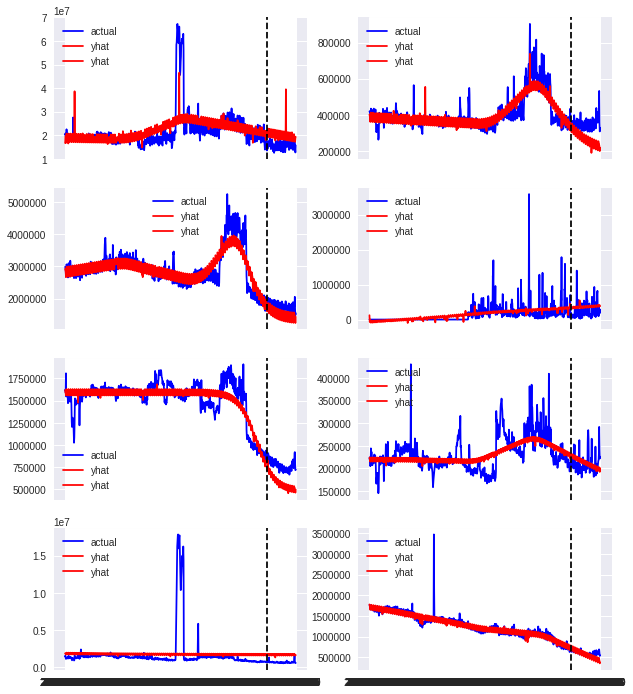

In [43]:
smape_prophet = []
fig = plt.figure(figsize=(10,12))
for i in range(8):
  # train-test split
  df_train = Prophet_format(data.iloc[max_visit_index[i],0:len_train],train_dates)
  df_test = Prophet_format(data.iloc[max_visit_index[i],len_train:len_train+len_test],test_dates)
  lang = language[i]
  
  # get language specific holiday
  if lang == 'en' or lang == 'na':
    holiday = holidays.US(years=[2015,2016,2017]) + holidays.UK(years=[2015,2016,2017]) + holidays.CA(years=[2015,2016,2017])
  if lang == 'de':
    holiday = holidays.DE(years=[2015,2016,2017])
  if lang == 'ja':
    holiday = holidays.JP(years=[2015,2016,2017])
  if lang == 'fr':
    holiday = holidays.FRA(years=[2015,2016,2017])
  if lang == 'es':
    holiday = holidays.MX(years=[2015,2016,2017]) + holidays.ES(years=[2015,2016,2017]) + holidays.AR(years=[2015,2016,2017])
  if lang == 'zh':
    holiday = holiday_zh('zh')
  if lang == 'ru':
    holiday = holiday_ru('ru')
  #convert holiday dictionary to dataframe
  holiday = pd.DataFrame.from_dict({'ds':i,'holiday':j} for i,j in holiday.items()) 
  
  df_train['cap'] = df_train.y.max()
  df_train['floor'] = df_train.y.min()
  df_test['cap'] = df_train.y.max()
  df_test['floor'] = df_train.y.min()
  
  # model and fit 
  model = Prophet(growth = 'logistic',
                  n_changepoints = 35,          #no of change points,default 25
                  changepoint_range=0.95,         #change points exist in the first 90% of time series,default 0.8    
                  changepoint_prior_scale = 0.15,  #adjust trend flexibility,default 0.05,increase if underfit
                  daily_seasonality=True,
                  holidays=holiday) 
  model.fit(df_train)  
  
  # fit over train period
  df_train_dates = pd.DataFrame({'ds':train_dates,'cap':df_train.cap,'floor':df_train.floor})
  train_fitted = model.predict(df_train_dates)
  # forecast over test period
  df_test_dates = pd.DataFrame({'ds':test_dates,'cap':df_test.cap,'floor':df_test.floor})
  future = model.predict(df_test_dates)
  
  # calculate smape of tested period
  smape_prophet.append(SMAPE(df_test.y.values,future.yhat.values))
  
  # plot 
  ax = fig.add_subplot(4,2,i+1)
  # plot actual time series
  ax.plot(data.iloc[max_visit_index[i],:],color='blue',label='actual')

  # plot fitted series
  ax.plot(range(len_train),train_fitted['yhat'],color = 'red')
  ax.plot(range(len_train,len_train+len_test),future.yhat,color = 'red')
  ax.axvline(x=len_train,color='k', linestyle='--')
  ax.legend()
  if i < 6:
    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

plt.show()

In [44]:
print(np.mean(smape_prophet))

34.60573967979177


Prophet does not need to assume stationarity to predict, which is a great advantage over ARIMA. In the model setting, I used daily seasonality, holiday, and also tune parameters including logistic growth, change points, portion of data having change points, and trend flexibity.   

The mean SMAPE of the predicted page visits over the test period is 34.6, higher than the value from ARIMA. By contrast, Prophet does not model the in-sample series as well as ARIMA since it is based on trend and seasonality. If change point position is not specified in parameter setting, it is unlikely to be captured. The out-of-sample predictions are greatly affected by the trend near the end of the training period.    

# LSTM

Recurrent neural network **(RNN)** is able to model time or sequence-dependent process.**Long Short-Term Memory Network (LSTM)** is a  a type of RNN that handles the vanishing gradient problem. Instead of neurons, LSTM networks have memory blocks that are connected through layers. A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.  
Input Gate: conditionally decides which values from the input to update the memory state.  
Output Gate: conditionally decides what to output based on input and the memory of the block.

In [36]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


**LSTM for Regression Using the Window Method**


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [38]:
testdata = data.iloc[max_visit_index[0],0:10]
testdata = testdata.reset_index()
testdata.drop('index',axis=1,inplace=True)
print(testdata.head())
newtest = create_dataset(testdata.values,3)
newtest

      38573
0  20381245
1  20752194
2  19573967
3  20439645
4  20772109


(array([[[20381245],
         [20752194],
         [19573967]],
 
        [[20752194],
         [19573967],
         [20439645]],
 
        [[19573967],
         [20439645],
         [20772109]],
 
        [[20439645],
         [20772109],
         [22544669]],
 
        [[20772109],
         [22544669],
         [21210887]],
 
        [[22544669],
         [21210887],
         [19107911]]]), array([[20439645],
        [20772109],
        [22544669],
        [21210887],
        [19107911],
        [19993848]]))

site no 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/10
 - 8s - loss: 0.0350
Epoch 2/10
 - 5s - loss: 0.0184
Epoch 3/10
 - 5s - loss: 0.0087
Epoch 4/10
 - 5s - loss: 0.0043
Epoch 5/10
 - 5s - loss: 0.0035
Epoch 6/10
 - 5s - loss: 0.0033
Epoch 7/10
 - 5s - loss: 0.0032
Epoch 8/10
 - 5s - loss: 0.0030
Epoch 9/10
 - 5s - loss: 0.0029
Epoch 10/10
 - 5s - loss: 0.0028
site no 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/10
 - 6s - loss: 0.0208
Epoch 2/10
 - 5s - loss: 0.0067
Epoch 3/10
 - 5s - loss: 0.0039
Epoch 4/10
 - 5s - loss: 0.0037
Epoch 5/10
 - 6s - loss: 0.0037
Epoch 6/10
 - 5s - loss: 0.0037
Epoch 7/10
 - 5s - loss: 0.0037
Epoch 8/10
 - 5s - loss: 0.0037
Epoch 9/10
 - 5s - loss: 0.0037
Epoch 10/10
 - 5s - loss: 0.0036
site no 2
Epoch 1/10
 - 6s - loss: 0.0214
Epoch 2/10
 - 6s - loss: 0.0042
Epoch 3/10
 - 6s - loss: 0.0034
Epoch 4/10
 - 6s - loss: 0.0032
Epoch 5/10
 - 6s - loss: 0.0032
Epoch 6/10
 - 6s - loss: 0.0032
Epoch 7/10
 - 6s - loss: 0.0031
Epoch 8/10
 - 6s - loss: 0.0031
Epoch 9/10
 - 6s - loss: 0.0031
Epoch 10/10
 - 6s - loss: 0.0031
site no 3
Epoch 1/10
 - 6s - loss: 0.0043
Epoch 2/10
 - 6s - loss: 0.0041
Epoch 3/10
 - 6s - loss: 0.0041
Epoch 4/10
 - 6s - loss: 0.0040
Epoch 5/10
 - 6s - loss: 0.0040
Epoch 6/10
 - 6s - loss: 0.0039
Epoch 7/10
 - 6s - loss: 0.0038
Epoch 8/10
 - 6s - loss: 0.0038
Epoch 9/10
 - 6s - loss: 0.0038
Epoch 10/10
 - 6s - loss: 0.0038
site no 4
Epoch 1

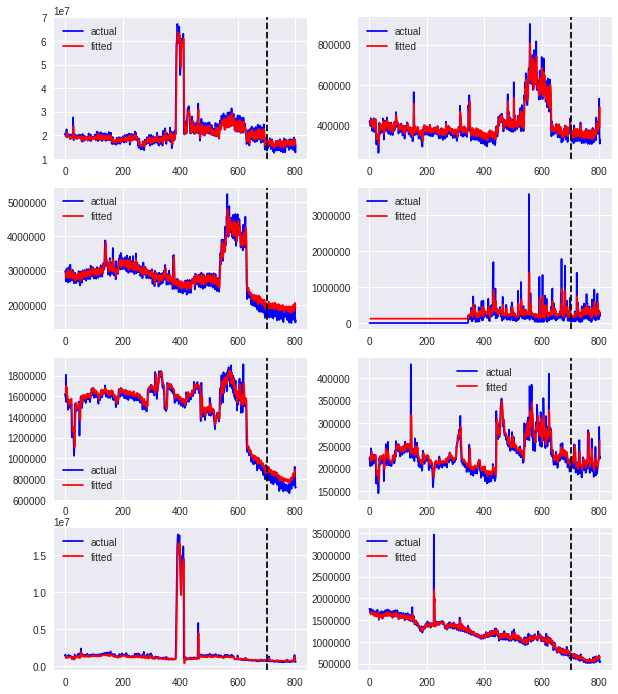

In [39]:
# fix random seed for reproducibility
np.random.seed(12)

# initiate smape matrix
smape_lstm = []
fig = plt.figure(figsize=(10,12))
                 
# loop through web pages
for i in range(8):
  print("site no "+str(i))
  # train-test split
  df_train = data.iloc[max_visit_index[i],0:len_train]
  df_test = data.iloc[max_visit_index[i],len_train:len_train+len_test]
  
  # normalize data
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_scaled = scaler.fit_transform(df_train.reshape(-1, 1))
  test_scaled = scaler.transform(df_test.reshape(-1, 1))
  
  # reshape into X=t and Y=t+1
  look_back = 3
  trainX, trainY = create_dataset(train_scaled, look_back)
  testX, testY = create_dataset(test_scaled, look_back)
  
  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
  
  # make predictions
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform(trainY.reshape(1,-1))
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform(testY.reshape(1,-1))
  
  # calculate smape of tested period
  smape_lstm.append(SMAPE(testY[0],testPredict[:,0]))
  
  # shift train predictions for plotting
  dataset = data.iloc[max_visit_index[i],0:len_train+len_test]
  dataset = scaler.transform(dataset.reshape(-1, 1))

  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # plot baseline and predictions
  ax = fig.add_subplot(4,2,i+1)
  ax.plot(scaler.inverse_transform(dataset),color='blue',label='actual')
  ax.plot(trainPredictPlot,color='red',label='fitted')
  ax.plot(testPredictPlot,color='red')
  ax.axvline(x=len_train,color='k', linestyle='--')
  ax.legend()
plt.show()

In [40]:
print(smape_lstm)
print(np.mean(smape_lstm))

[8.375923451433975, 6.881655449887584, 9.644355203682398, 66.61784794976683, 7.173159823581236, 7.5521182227711705, 16.63799911157704, 6.359897740428478]
16.15536961914109


Here a LSTM network was built. The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 10 epochs and a batch size of 1 is used. A window method is used so that multiple recent time steps can be used to make the prediction for the next time step. In this case, with a look back of 3 steps, it used data of t-2, t-1, and t to predict the value at t+1.   

The mean SMAPE value of the 8 pages over the test period is 16.1, lower than the SMAPE gotten from ARIMA and Prophet. Therefore, LSTM outperforms ARIMA and Prophet in forecast page visits of the eight articles. 